# Evaluation & Visuals

### Imports & paths

In [26]:
import os
import sys

# Absolute path to your project root
PROJECT_ROOT = r"C:\Users\Maria\Desktop\projects\sentiment-analysis"

# Add to sys.path so Python can import from src/
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

print("Added to path:", PROJECT_ROOT)
print("Folders in PROJECT_ROOT:", os.listdir(PROJECT_ROOT))

Added to path: C:\Users\Maria\Desktop\projects\sentiment-analysis
Folders in PROJECT_ROOT: ['.venv', 'data', 'models', 'notebooks', 'README.md', 'requirements.txt', 'src', 'venv', 'visuals']


In [27]:
import json
import os

import matplotlib.pyplot as plt
from datasets import load_dataset
from joblib import load
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

from src.config import DEFAULT_MODEL_PATH

### Load dataset & model

In [28]:
dataset = load_dataset("imdb")
test_texts = dataset["test"]["text"]
test_labels = dataset["test"]["label"]

model = load(DEFAULT_MODEL_PATH)

len(test_texts), len(test_labels)

(25000, 25000)

### Evaluate & confusion matrix

Test accuracy (loaded model): 0.8930

Classification report:
              precision    recall  f1-score   support

    NEGATIVE       0.89      0.89      0.89     12500
    POSITIVE       0.89      0.89      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000



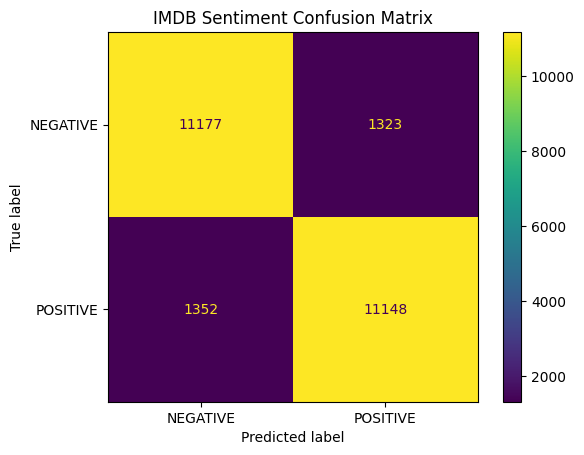

In [29]:
test_preds = model.predict(test_texts)
acc = accuracy_score(test_labels, test_preds)
print(f"Test accuracy (loaded model): {acc:.4f}")

print("\nClassification report:")
print(classification_report(test_labels, test_preds, target_names=["NEGATIVE", "POSITIVE"]))

cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NEGATIVE", "POSITIVE"])
disp.plot()
plt.title("IMDB Sentiment Confusion Matrix")
plt.show()

### ROC Curve (Receiver Operating Characteristic)
Shows how well your classifier separates the classes across all thresholds.

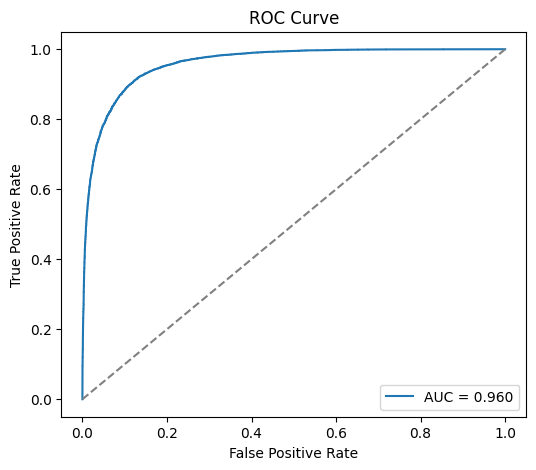

In [30]:
from sklearn.metrics import roc_curve, auc

proba = model.predict_proba(test_texts)[:, 1]
fpr, tpr, _ = roc_curve(test_labels, proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

### Most Important Positive and Negative Words

Label counts in subset: (array([0, 1]), array([5038, 4962], dtype=int64))
Training interpretability (LogReg) model...
Validation accuracy (LogReg interpretability model): 0.8800


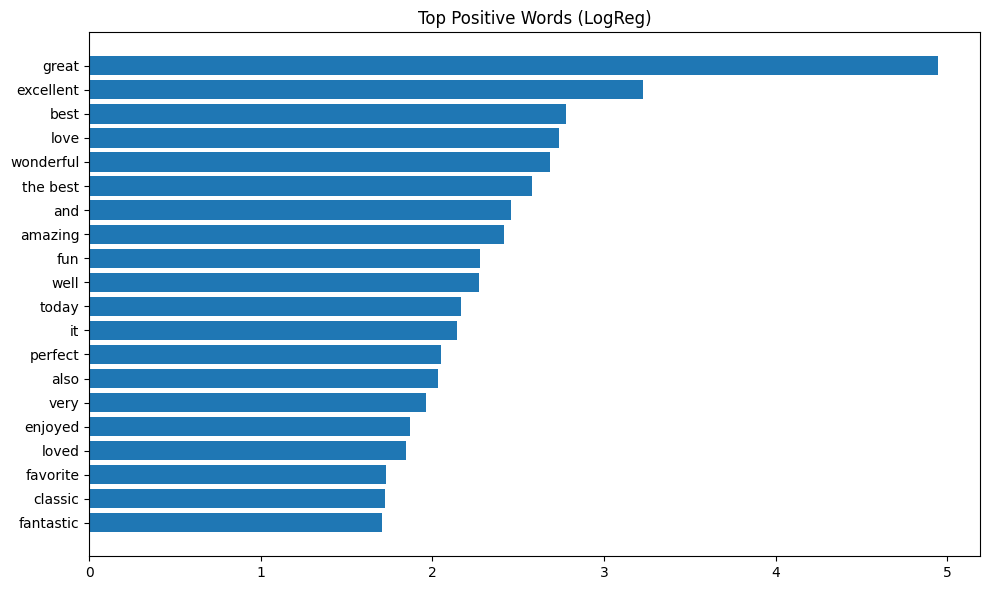

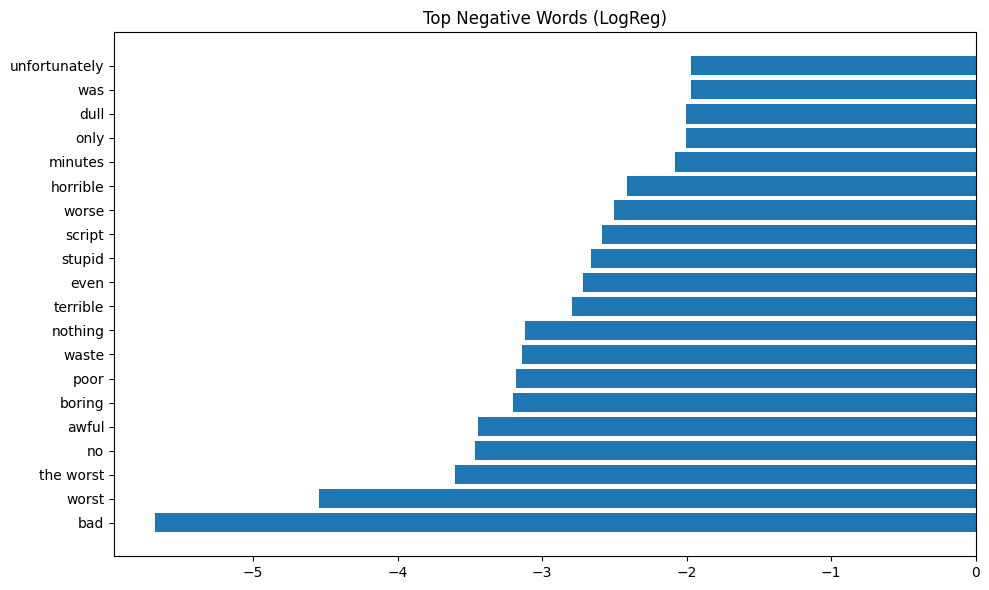

In [31]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from datasets import load_dataset

# 1) Load IMDB dataset
dataset = load_dataset("imdb")
train_texts = dataset["train"]["text"]
train_labels = dataset["train"]["label"]

# 2) Shuffle before subsampling (IMPORTANT)
X_shuf, y_shuf = shuffle(train_texts, train_labels, random_state=42)

# 3) Subset (for speed)
SUBSET_SIZE = 10000
X_sub = X_shuf[:SUBSET_SIZE]
y_sub = y_shuf[:SUBSET_SIZE]

# 4) Check labels
print("Label counts in subset:", np.unique(y_sub, return_counts=True))

# 5) Split
X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(
    X_sub, y_sub, test_size=0.2, random_state=42, stratify=y_sub
)

# 6) Model for interpretability
interp_model = Pipeline(
    steps=[
        ("tfidf", TfidfVectorizer(max_features=20000, ngram_range=(1, 2))),
        ("clf", LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42)),
    ]
)

print("Training interpretability (LogReg) model...")
interp_model.fit(X_train_sub, y_train_sub)
val_acc = interp_model.score(X_val_sub, y_val_sub)
print(f"Validation accuracy (LogReg interpretability model): {val_acc:.4f}")

# 7) Get feature importance
tfidf = interp_model.named_steps["tfidf"]
clf = interp_model.named_steps["clf"]

feature_names = np.array(tfidf.get_feature_names_out())
coef = clf.coef_[0]

# 8) Plot
top_n = 20

top_positive_idx = coef.argsort()[-top_n:]
top_negative_idx = coef.argsort()[:top_n]

top_positive = feature_names[top_positive_idx]
top_negative = feature_names[top_negative_idx]

top_positive_coef = coef[top_positive_idx]
top_negative_coef = coef[top_negative_idx]

plt.figure(figsize=(10, 6))
plt.barh(top_positive, top_positive_coef)
plt.title("Top Positive Words (LogReg)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.barh(top_negative, top_negative_coef)
plt.title("Top Negative Words (LogReg)")
plt.tight_layout()
plt.show()

### Inspect one or two errors

In [32]:
import numpy as np

test_texts = np.array(test_texts)
test_labels = np.array(test_labels)

mis_idx = np.where(test_preds != test_labels)[0]
len(mis_idx)

2675

In [33]:
# Shows a few misclassified examples
for i in mis_idx[:5]:
    true_label = "POSITIVE" if test_labels[i] == 1 else "NEGATIVE"
    pred_label = "POSITIVE" if test_preds[i] == 1 else "NEGATIVE"
    print("-----")
    print(f"True: {true_label} | Pred: {pred_label}")
    print(test_texts[i][:500], "...")

-----
True: NEGATIVE | Pred: POSITIVE
First off let me say, If you haven't enjoyed a Van Damme movie since bloodsport, you probably will not like this movie. Most of these movies may not have the best plots or best actors but I enjoy these kinds of movies for what they are. This movie is much better than any of the movies the other action guys (Segal and Dolph) have thought about putting out the past few years. Van Damme is good in the movie, the movie is only worth watching to Van Damme fans. It is not as good as Wake of Death (whi ...
-----
True: NEGATIVE | Pred: POSITIVE
Ben, (Rupert Grint), is a deeply unhappy adolescent, the son of his unhappily married parents. His father, (Nicholas Farrell), is a vicar and his mother, (Laura Linney), is ... well, let's just say she's a somewhat hypocritical soldier in Jesus' army. It's only when he takes a summer job as an assistant to a foul-mouthed, eccentric, once-famous and now-forgotten actress Evie Walton, (Julie Walters), that he finally 